# Simulated Maximum Likelihood with PFJAX

**Martin Lysy -- University of Waterloo**

**May 4, 2022**

## Summary

In this module we demontrate how to maximize the marginal likelihood for the state-space model,

$$
\begin{aligned}
\Ell(\tth) & = p(\yy_{0:T} \mid \tth) \\
& = \int \prod_{t=0}^T p(\yy_t \mid \xx_t, \tth) \times \prod_{t=1}^T p(\xx_t \mid \xx_{t-1}, \tth) \times p(\xx_0 \mid \tth)\, d \xx_{0:T},   
\end{aligned}
$$

using a particle filter approximation for $\Ell(\tth)$.  In particular:

- We obtain particle filter estimates of $\ell(\tth) = \log \Ell(\tth)$ and $\nabla \ell(\tth)$ in order to conduct stochastic optimization in search of $\hat \tth = \argmax_{\tth} \ell(\tth)$.

- We obtain a particle filter estimate of $\nabla^2 \ell(\tth)$ to be used for variance estimation, e.g., for calculating standard errors.

## Example: Brownian Motion with Drift

The model is
$$
\begin{aligned}
x_0 & \sim \pi(x_0) \propto 1 \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2),
\end{aligned}
$$

with $\tth = (\mu, \sigma, \tau)$.  Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.  In this case, the marginal likelihood is defined as 

$$
\Ell(\tth) = p(\yy_{1:T} \mid y_0, \tth)
$$

rather than by $p(\yy_{0:T} \mid \tth)$.  The reason is that the latter expression requires one to integrate over $x_0 \sim \pi(x_0)$, which can only be done when $\pi(x_0)$ is a proper prior.  However, for our choice of $\pi(x_0) \propto 1$ this is not the case.  On the other hand, $p(\yy_{1:T} \mid y_0, \tth)$ only requires us to integrate over $p(x_0 \mid y_0, \tth)$, which only requires this distribution to be proper, as is the case here.

Brownian motion with drift is a simple model that will serve as a benchmark for further experiments. Note that in this particular model, we have access to the closed form of $\Ell(\tth)$ (see below for derivation). Since our method is an approximation method, it will serve as a reasonable sanity check and debugging tool to ensure that our method is not only technically sound, but also empirically verifiable.

## Simulate Data

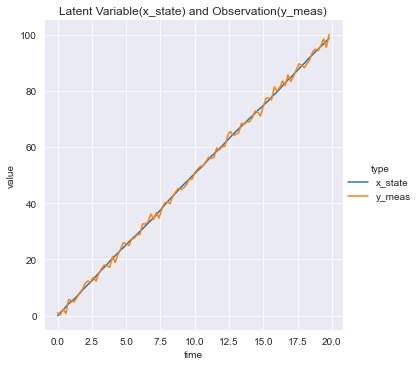

In [1]:
import numpy as np
from functools import partial
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp

import pfjax as pf
import pfjax.experimental.particle_filter as pfex
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = 0.

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");


## Check Particle Filter Approximations

Let $\hat \ell_N(\tth)$ denote a particle filter estimate of $\ell(\tth)$ with $N$ particles, and similar notations for $\widehat{\nabla \ell}_N(\tth)$ and $\widehat{\nabla^2 \ell}_N(\tth)$.  Our purpose here is to check that

$$
\begin{aligned}
\hat \ell_N(\tth) & \to \ell(\tth) \\
\widehat{\nabla \ell}_N(\tth) & \to \nabla \ell(\tth) \\
\widehat{\nabla^2 \ell}_N(\tth) & \to \nabla^2 \ell(\tth)
\end{aligned}
$$

as $N \to \infty$.  
<!-- The usual way of estimating the score and Hessian functions $\nabla \ell(\tth)$ and $\nabla^2 \ell(\tth)$ is described in e.g., Cappe et al (2005), Poyiadjis et al (2011).  Here we would like leverage the power of the JAX autodiff engine to just differentiate through the particle filter, i.e,. $\widehat{\nabla \ell}_N(\tth) = \nabla \hat{\ell}_N(\tth)$ and $\widehat{\nabla^2 \ell}_N(\tth) = \nabla^2 \hat{\ell}_N(\tth)$. -->

### Loglikelihood Check

<!-- We'll proceed on the negative scale, which converts the MLE to a minimization problem for which most optimization algorithms are naturally defined.  Also, we'll convert the parameter to an unconstrained scale, $\pph = (\mu, \log \sigma, \log \tau)$.
 -->
 
We will consider two different particle filter algorithms for this problem:

1.  A standard bootstrap particle filter with multinomial resampling \cite{doucet.johansen09}.  The complexity of this particle filter is $\bO(NT)$ and the storage cost is $\bO(N)$.

2.  A Rao-Blackwellized bootstrap particle filter described by \cite{poyiadjis.etal11}.  The complexity of this algorithm is $\bO(N^2T)$ and the storage cost is $\bO(N)$.

Here we'll content ourselves with a visual assessment using projection plots about the true parameter value.
 
**Warning:** The code below occasionally makes use of global variables, thus violating the functional programming paradigm of JAX.  Changing these global variables after jitting will lead to incorrect results.

In [6]:
def to_phi(theta):
    """
    Helper function to convert theta to phi.
    """
    return jnp.array([theta[0], jnp.log(theta[1]), jnp.log(theta[2])])

def to_theta(phi):
    """
    Helper function to convert phi to theta.
    """
    return jnp.array([phi[0], jnp.exp(phi[1]), jnp.exp(phi[2])])

def prop_lpdf(self, x_curr, x_prev, y_curr, theta):
    """
    Add proposal log-pdf to bm_model.
    """
    return self.state_lpdf(x_curr=x_curr, x_prev=x_prev, theta=theta)

def bm_loglik_exact(theta, y_meas):
    """
    Exact loglikelihood of the BM model.
    """
    return bm_model.loglik_exact(y_meas=y_meas, theta=theta)

def bm_loglik_stan(theta, y_meas, key, n_particles):
    """
    Standard particle filter approximation of the loglikelihood.
    """
    pf_out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

def bm_loglik_rb(theta, y_meas, key, n_particles):
    """
    Rao-Blackwellized particle filter approximation of the negative loglikelihood.
    """
    pf_out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        history=False
    )
    return pf_out["loglik"]

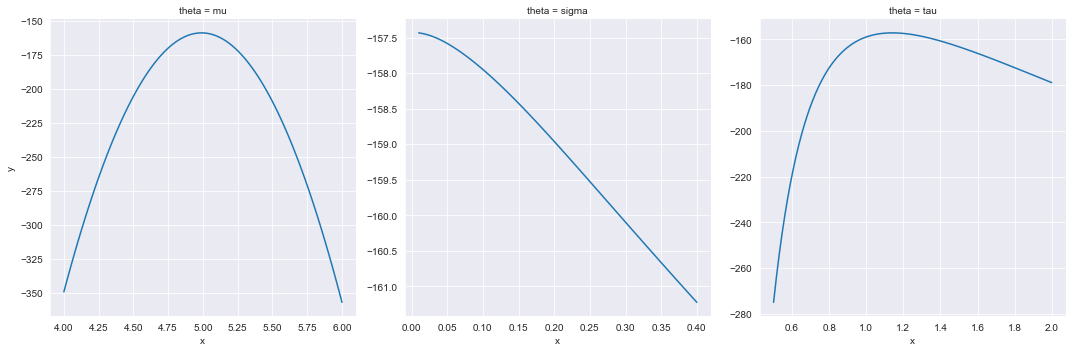

In [7]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for `projplot.projxvals()` and `projplot.projdata()`.
    
    Won't need this for upcoming interface of projplot.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

# plot exact likelihood
theta_lims = jnp.array([[4., 6.], [.01, .4], [.5, 2]]) # for n_obs = 100
# theta_lims = jnp.array([[4., 5.5], [.01, .4], [.8, 1.4]]) # for n_obs = 10
# phi_true = to_phi(theta_true)
# phi_lims = to_phi(theta_lims)

theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
df_exact = proj_data(jax.jit(partial(bm_loglik_exact, y_meas=y_meas)),
                    theta_true, theta_lims, theta_names, n_pts=n_pts)

68.2 ms ± 6.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


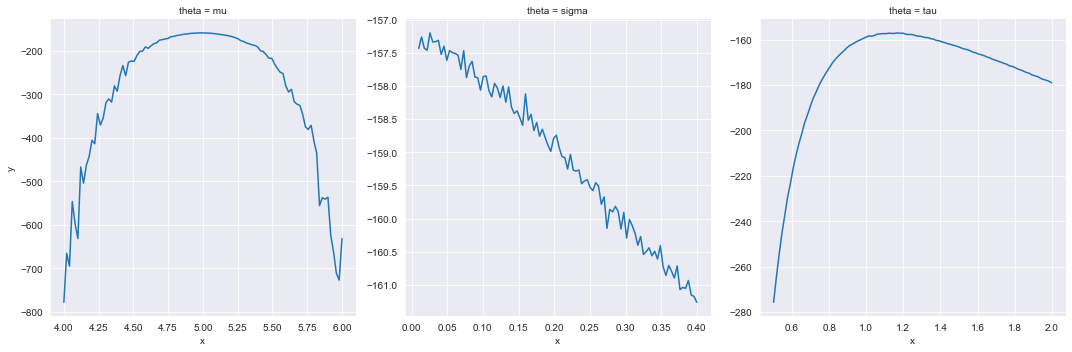

In [8]:
# standard particle filter

n_particles_stan = 2500

key, subkey = random.split(key)
bm_ll_stan = jax.jit(partial(bm_loglik_stan, y_meas=y_meas,
                             n_particles=n_particles_stan, key=subkey))

%timeit bm_ll_stan(theta_true)

df_stan = proj_data(bm_ll_stan,
                    theta_true, theta_lims, theta_names)

24.6 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


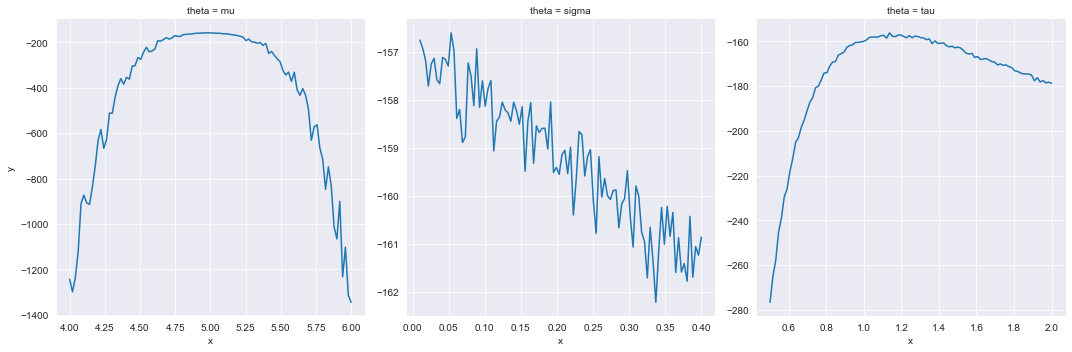

In [11]:
# rao-blackwellized particle filter

n_particles_rb = 100

key, subkey = random.split(key)
bm_ll_rb = jax.jit(partial(bm_loglik_rb, y_meas=y_meas,
                             n_particles=n_particles_rb, key=subkey))

%timeit bm_ll_rb(theta_true)

df_rb = proj_data(bm_ll_rb,
                    theta_true, theta_lims, theta_names)

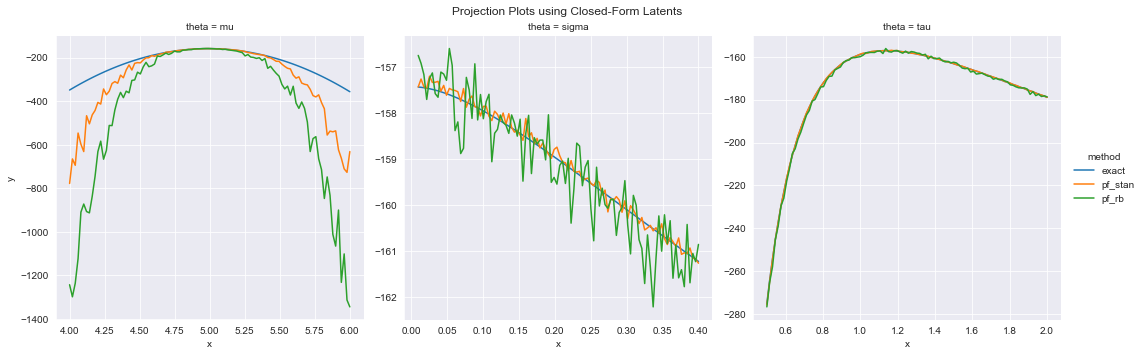

In [12]:
plot_df = pd.concat([df_exact, df_stan, df_rb], ignore_index=True)
plot_df["method"] = np.repeat(["exact", "pf_stan", "pf_rb"], len(df_exact["theta"]))
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", 
    hue="method",
    col="theta",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots using Closed-Form Latents');

**Conclusions:** 

- We used 1000 particles for the standard filter but only 100 particles for the Rao-Blackwellized filter.  The latter takes longer to compute but supposedly has lower variance.  In this particular case it does not seem to be the case, i.e., the Rao-Blackwellized filter takes longer and appears to be more variable.

- Both particle filters reasonably approximate $\ell(\tth)$ when $\mu$ is at its true value.  They don't do so well when $\mu$ is far from its true value.  This may have to do with particle degeneracy in that case.

### Check Score Function

Here we'll compare three different approximations:

1.  Automatic differentiation through the standard particle filter.  This is know to produce biased results (\cite{corenflos.etal21}).

2.  A modification of the standard particle filter developed by \cite{cappe.moulines05} of which the bi-product is the score.  This algorithm is unbiased and scales as $\bO(NT)$, but we have $\var(\widehat{\nabla \ell}_N(\tth)) = \bO{T^2/N}$ (\cite{{poyiadjis.etal11}).

3.  A bi-product of the Rao-Blackwellized particle filter developped by \cite{poyiadjis.etal11}.

    **Update:** This has a bug somewhere...

For simplicity we'll just check the various approximations at the true value of $\tth$.

In [13]:
# various score functions

bm_score_exact = jax.jit(jax.grad(partial(bm_loglik_exact, y_meas=y_meas)))


@partial(jax.jit, static_argnums=(2,))
def bm_score_auto(theta, key, n_particles):
    return jax.grad(bm_loglik_stan)(theta, y_meas, key, n_particles)


@partial(jax.jit, static_argnums=(2,))
def bm_score_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


@partial(jax.jit, static_argnums=(2,))
def bm_score_rb(theta, key, n_particles): 
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=False,
        history=False
    )
    return out["score"]


In [15]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit bm_score_auto(theta_true, key, n_particles_stan)
%timeit bm_score_acc(theta_true, key, n_particles_stan)
%timeit bm_score_rb(theta_true, key, n_particles_rb)

91.8 ms ± 6.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
64.1 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
44.7 ms ± 714 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
# repeat calculation nsim times
score_exact = bm_score_exact(theta_true)
score_auto = []
score_acc = []
score_rb = []

for i in range(n_sim):
    score_auto += [bm_score_auto(theta_true, subkeys[i], n_particles_stan)]
    score_acc += [bm_score_acc(theta_true, subkeys[i], n_particles_stan)]
    score_rb += [bm_score_rb(theta_true, subkeys[i], n_particles_rb)]

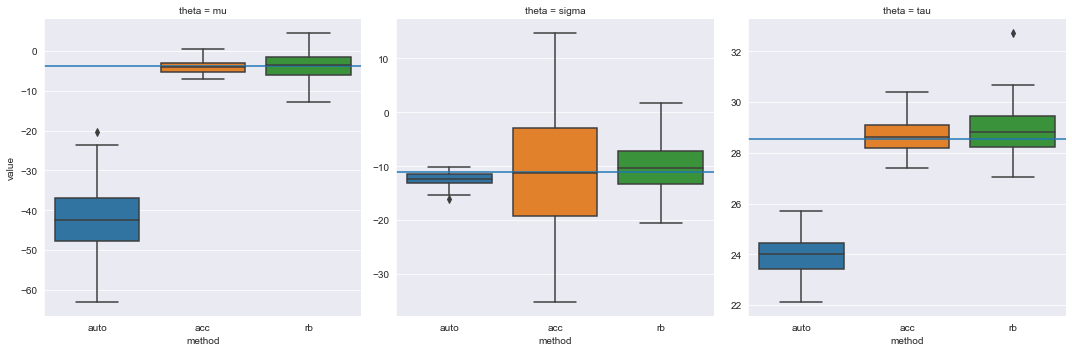

In [18]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "auto": np.array(score_auto).ravel(),
    "acc": np.array(score_acc).ravel(),
    "rb": np.array(score_rb).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true.size)];

**Conclusions**:

- This confirms that autodiff through the particle filter is biased (in $\mu$ and $\tau$) whearas the other two filters are not.

- The advantage of the Rao-Blackwellized score calculation is evident for $\sigma$.

### Check Fisher Information

We'll do this using the same methods as for the score.

In [19]:
# various fisher information calculations

bm_fisher_exact = jax.jit(
    jax.jacfwd(jax.jacrev(partial(bm_loglik_exact, y_meas=y_meas)))
)


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_auto(theta, key, n_particles):
    return jax.jacfwd(jax.jacrev(bm_loglik_stan))(theta, y_meas, key, n_particles)


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_acc(theta, key, n_particles):
    out = pfex.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    return out["fisher"]


@partial(jax.jit, static_argnums=(2,))
def bm_fisher_rb(theta, key, n_particles):
    out = pfex.particle_filter_rb(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles,
        score=True,
        fisher=True,
        history=False
    )
    return out["fisher"]

In [ ]:
key = random.PRNGKey(0)
n_particles_stan = 2500
n_particles_rb = 100
n_sim = 100
key, *subkeys = random.split(key, n_sim+1)

# check timings
%timeit bm_fisher_auto(theta_true, key, n_particles_stan)
%timeit bm_fisher_acc(theta_true, key, n_particles_stan)
%timeit bm_fisher_rb(theta_true, key, n_particles_rb)

In [24]:
# repeat calculation nsim times
fisher_exact = bm_fisher_exact(theta_true)
fisher_auto = []
fisher_acc = []
fisher_rb = []

for i in range(n_sim):
    fisher_auto += [bm_fisher_auto(theta_true, subkeys[i], n_particles_stan)]
    fisher_acc += [bm_fisher_acc(theta_true, subkeys[i], n_particles_stan)]
    fisher_rb += [bm_fisher_rb(theta_true, subkeys[i], n_particles_rb)]

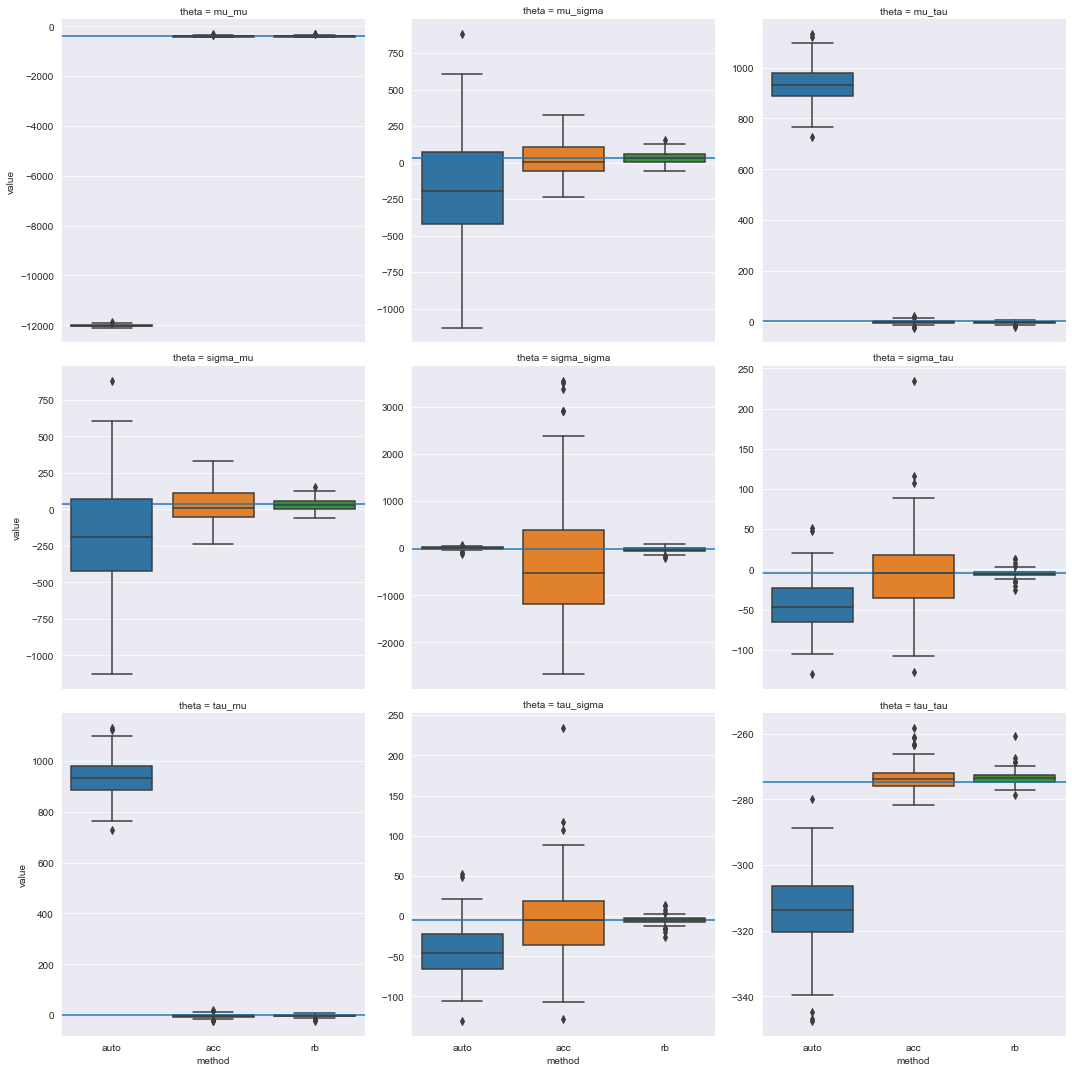

In [25]:
theta2_names = np.meshgrid(np.array(theta_names), np.array(theta_names))
theta2_names = np.array(
    [theta2_names[1].ravel()[i] + '_' +
     theta2_names[0].ravel()[i]
     for i in range(theta2_names[0].size)]
)

plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta2_names, n_sim),
    "auto": np.array(fisher_auto).ravel(),
    "acc": np.array(fisher_acc).ravel(),
    "rb": np.array(fisher_rb).ravel()
})
    .melt(id_vars=["theta"], value_vars=["auto", "acc", "rb"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(fisher_exact.ravel()[i]) for i in range(theta2_names.size)];

**Conclusions**:

- In this case the Rao-Blackwellized filter is the clear winner, in terms of accuracy and precision.  It does that ~10x longer than the standard filter, so a more careful evaluation with similar timings is needed.

## Appendix: Exact Likelihood of the BM Model

The distribution of $p(\xx_{0:T}, \yy_{1:T} \mid y_0, \tth)$ is multivariate normal.  Thus we only need to find  $E[\yy_{1:T} \mid y_0, \tth]$ and $\var(\yy_{1:T} \mid y_0, \tth)$.

Conditioned on $x_0$ and $\tth$, the Brownian latent variables $\xx_{1:T}$ are multivariate normal with
$$
\newcommand{\cov}{\operatorname{cov}}
\begin{aligned}
%E[x_0 \mid \tth] & = y_0 & \var(x_0\\
E[x_t \mid x_0, \tth] & = x_0 + \mu t, \\
\cov(x_s, x_t \mid x_0, \tth) & = \sigma^2 \min(s, t).
\end{aligned}
$$
Conditioned on $\xx_{0:T}$ and $\tth$, the measurement variables $\yy_{1:T}$ are multivariate normal with
$$
\begin{aligned}
E[y_t \mid \xx_{0:T}, \tth] & = \xx_{1:T}, \\
\cov(y_s, y_t \mid \xx_{0:T}, \tth) & = \tau^2 \delta_{st}.
\end{aligned}
$$
Therefore, the marginal distribution of $\yy_{1:T}$ is multivariate normal with
$$
\begin{aligned}
E[y_t \mid x_0, \tth] 
& = E[E[y_t \mid \xx_{0:T}, \tth] \mid x_0, \tth] \\
& = x_0 + \mu t \\
\cov(y_s, y_t \mid x_0, \tth) 
& = \cov(E[y_s \mid \xx_{0:T}, \tth], E[y_t \mid \xx_{0:T}] \mid \tth) + E[\cov(y_s, y_t \mid \xx_{0:T}, \tth) \mid \tth] \\
& = \sigma^2 \min(s, t) + \tau^2 \delta_{st}.
\end{aligned}
$$
For the given choice of prior, we have $x_0 \mid y_0 \sim \N(y_0, \tau^2)$ for the initial observation $y_0$.  Integrating over $x_0$, the marginal distribution of $\yy_{1:T}$ is MVN with
$$
\begin{aligned}
E[y_t \mid y_0, \tth] & = y_0 + \mu t, \\
\cov(y_s, y_t \mid y_0, \tth) & = \sigma^2 \min(s, t) + \tau^2(\delta_{st} + 1).
\end{aligned}
$$